# LifeSnaps Analysis Notebook Experiments

## 1. Setup and Data Loading

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, f1_score, make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline  # Use imblearn pipeline for resampling

import joblib # For saving models if needed
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('../data/df_cleaned.csv')

print("Dataset loaded successfully.")
print(f"Shape: {df.shape}")


Dataset loaded successfully.
Shape: (7410, 25)


## 2. Initial data preprocessint
Handle missing target values, identify features and targets, and prepare for further processing.

In [2]:

# Separate data based on target availability
df_complete_targets = df.dropna(subset=["TENSE/ANXIOUS", "TIRED"])
df_missing_targets = df[df["TENSE/ANXIOUS"].isnull() | df["TIRED"].isnull()]

print(f"Shape with complete targets: {df_complete_targets.shape}")
print(f"Shape with missing targets: {df_missing_targets.shape}")

# Define features (X) and targets (y)
# We will predict TENSE/ANXIOUS and TIRED separately
features = df_complete_targets.drop(columns=["TENSE/ANXIOUS", "TIRED"])
target_tense = df_complete_targets["TENSE/ANXIOUS"].astype(int)
target_tired = df_complete_targets["TIRED"].astype(int)

# Identify numerical and categorical features
numerical_features = features.select_dtypes(include=np.number).columns.tolist()
categorical_features = features.select_dtypes(exclude=np.number).columns.tolist()

print(f"\nNumerical features ({len(numerical_features)}): {numerical_features}")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")

# Define preprocessing steps
# Initial imputation strategy: Median for numerical, Most Frequent for categorical
# KNN imputation will be tested later as per requirements
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))])

# Create the preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features)])

# Split data into training and testing sets (using data with complete targets)
# We'll use a consistent random_state for reproducibility
X_train, X_test, y_tense_train, y_tense_test = train_test_split(
    features, target_tense, test_size=0.2, random_state=42, stratify=target_tense
)

# Use the same split for the TIRED target
_, _, y_tired_train, y_tired_test = train_test_split(
    features, target_tired, test_size=0.2, random_state=42, stratify=target_tired
)

print(f"\nTrain set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"TENSE/ANXIOUS Train target distribution:\n{y_tense_train.value_counts(normalize=True)}")
print(f"TENSE/ANXIOUS Test target distribution:\n{y_tense_test.value_counts(normalize=True)}")
print(f"TIRED Train target distribution:\n{y_tired_train.value_counts(normalize=True)}")
print(f"TIRED Test target distribution:\n{y_tired_test.value_counts(normalize=True)}")

# Note: The preprocessor will be fitted ONLY on X_train within the model pipeline
# to prevent data leakage from the test set.



Shape with complete targets: (2290, 25)
Shape with missing targets: (5120, 25)

Numerical features (20): ['nightly_temperature', 'nremhr', 'rmssd', 'spo2', 'full_sleep_breathing_rate', 'stress_score', 'daily_temperature_variation', 'calories', 'bpm', 'sedentary_minutes', 'resting_hr', 'minutesAsleep', 'minutesAwake', 'sleep_efficiency', 'sleep_deep_ratio', 'sleep_wake_ratio', 'sleep_light_ratio', 'sleep_rem_ratio', 'steps', 'bmi']
Categorical features (3): ['age', 'gender', 'bmi_tipo']

Train set shape: (1832, 23)
Test set shape: (458, 23)
TENSE/ANXIOUS Train target distribution:
TENSE/ANXIOUS
0    0.780022
1    0.219978
Name: proportion, dtype: float64
TENSE/ANXIOUS Test target distribution:
TENSE/ANXIOUS
0    0.779476
1    0.220524
Name: proportion, dtype: float64
TIRED Train target distribution:
TIRED
0    0.615721
1    0.384279
Name: proportion, dtype: float64
TIRED Test target distribution:
TIRED
0    0.615721
1    0.384279
Name: proportion, dtype: float64


## 3. Baseline Model Training (Handling Imbalance)

Define and train the four classifiers (MLP, SVM, RandomForest, GradientBoosting) for both targets. We will use `imblearn` pipelines to incorporate SMOTE for handling class imbalance and `GridSearchCV` for hyperparameter tuning, optimizing for macro F1-score.

In [ ]:
# Define classifiers
classifiers = {
    "MLP": MLPClassifier(random_state=42, max_iter=1000), # Increased max_iter for convergence
    "SVM": SVC(random_state=42, probability=True), # probability=True for potential calibration later if needed
    "RandomForest": RandomForestClassifier(random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42)
}

# Define parameter grids for GridSearchCV
# Reduced complexity for faster initial run, can be expanded
param_grids = {
    "MLP": {
        "classifier__hidden_layer_sizes": [(50,), (100,), (50, 50)],
        "classifier__activation": ["relu", "tanh"],
        "classifier__alpha": [0.0001, 0.001],
        # Add learning_rate_init if using 'adam' solver (default)
        # "classifier__learning_rate_init": [0.001, 0.01]
    },
    "SVM": {
        "classifier__C": [0.1, 1, 10],
        "classifier__kernel": ["rbf", "linear"],
        # Gamma is only for rbf kernel, GridSearchCV handles this
        "classifier__gamma": ["scale", "auto", 0.1]
    },
    "RandomForest": {
        "classifier__n_estimators": [100, 200],
        "classifier__max_depth": [None, 10, 20],
        "classifier__min_samples_split": [2, 5],
        "classifier__min_samples_leaf": [1, 3],
        "classifier__class_weight": ["balanced", "balanced_subsample"]
    },
    "GradientBoosting": {
        "classifier__n_estimators": [100, 200],
        "classifier__learning_rate": [0.05, 0.1],
        "classifier__max_depth": [3, 5],
        "classifier__subsample": [0.8, 1.0]
    }
}

# Define scoring metric and CV strategy
f1_macro_scorer = make_scorer(f1_score, average="macro")
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store results
baseline_results = []
baseline_models = {}

# Targets to predict
targets = {
    "TENSE/ANXIOUS": (y_tense_train, y_tense_test),
    "TIRED": (y_tired_train, y_tired_test)
}

# --- Training Loop ---
for target_name, (y_train, y_test) in targets.items():
    print(f"\n--- Training models for target: {target_name} ---")
    baseline_models[target_name] = {}
    for model_name, classifier in classifiers.items():
        print(f"Training {model_name}...")

        # Create pipeline with preprocessing, SMOTE, and classifier
        # Use ImbPipeline to ensure SMOTE is applied correctly during CV
        pipeline = ImbPipeline([
            ("preprocessor", preprocessor),
            ("smote", SMOTE(random_state=42)), # Apply SMOTE to handle imbalance
            ("classifier", classifier)
        ])

        # Perform Grid Search
        grid_search = GridSearchCV(
            pipeline,
            param_grids[model_name],
            scoring=f1_macro_scorer,
            cv=cv_strategy,
            n_jobs=-1, # Use all available cores
            verbose=1 # Show progress
        )

        try:
            grid_search.fit(X_train, y_train)

            # Store best estimator
            best_estimator = grid_search.best_estimator_
            baseline_models[target_name][model_name] = best_estimator

            # Evaluate on test set
            y_pred = best_estimator.predict(X_test)
            test_f1_macro = f1_score(y_test, y_pred, average="macro")
            report = classification_report(y_test, y_pred, output_dict=True)

            # Store results
            result_entry = {
                "Target": target_name,
                "Model": model_name,
                "Best Params": grid_search.best_params_,
                "Best CV F1-Macro": grid_search.best_score_,
                "Test F1-Macro": test_f1_macro,
                "Test Precision (Class 0)": report["0"]["precision"],
                "Test Recall (Class 0)": report["0"]["recall"],
                "Test F1 (Class 0)": report["0"]["f1-score"],
                "Test Precision (Class 1)": report["1"]["precision"],
                "Test Recall (Class 1)": report["1"]["recall"],
                "Test F1 (Class 1)": report["1"]["f1-score"],
            }
            baseline_results.append(result_entry)

            print(f"Best CV F1-Macro for {model_name}: {grid_search.best_score_:.4f}")
            print(f"Test F1-Macro for {model_name}: {test_f1_macro:.4f}")

        except Exception as e:
            print(f"Error training {model_name} for {target_name}: {e}")
            # Store partial results or indicate failure
            result_entry = {
                "Target": target_name,
                "Model": model_name,
                "Best Params": "Error",
                "Best CV F1-Macro": np.nan,
                "Test F1-Macro": np.nan
            }
            baseline_results.append(result_entry)

# Convert results to DataFrame
baseline_results_df = pd.DataFrame(baseline_results)

print("\n--- Baseline Model Training Complete ---")

# Display results
print("\nBaseline Model Performance Summary:")
# Display relevant columns
display_cols = ["Target", "Model", "Best CV F1-Macro", "Test F1-Macro", "Test F1 (Class 0)", "Test F1 (Class 1)"]




--- Training models for target: TENSE/ANXIOUS ---
Training MLP...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best CV F1-Macro for MLP: 0.5704
Test F1-Macro for MLP: 0.5304
Training SVM...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best CV F1-Macro for SVM: 0.5711
Test F1-Macro for SVM: 0.5551
Training RandomForest...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best CV F1-Macro for RandomForest: 0.6016
Test F1-Macro for RandomForest: 0.6101
Training GradientBoosting...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best CV F1-Macro for GradientBoosting: 0.5810
Test F1-Macro for GradientBoosting: 0.5800

--- Training models for target: TIRED ---
Training MLP...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best CV F1-Macro for MLP: 0.5030
Test F1-Macro for MLP: 0.5167
Training SVM...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best CV F1-Macro for SVM: 0.5195
Test F1-Macro for SVM: 0.4672

In [4]:
display(baseline_results_df[display_cols].round(4))

,Target,Model,Best CV F1-Macro,Test F1-Macro,Test F1 (Class 0),Test F1 (Class 1)
0,TENSE/ANXIOUS,MLP,0.5704,0.5304,0.7847,0.2762
1,TENSE/ANXIOUS,SVM,0.5711,0.5551,0.8154,0.2947
2,TENSE/ANXIOUS,RandomForest,0.6016,0.6101,0.8587,0.3614
3,TENSE/ANXIOUS,GradientBoosting,0.5810,0.5800,0.8248,0.3351
4,TIRED,MLP,0.5030,0.5167,0.6106,0.4228
5,TIRED,SVM,0.5195,0.4672,0.5509,0.3834
6,TIRED,RandomForest,0.5243,0.5276,0.6493,0.4059
7,TIRED,GradientBoosting,0.5211,0.5085,0.5664,0.4505


This code block defines the models, parameter grids, performs the cross-validated hyperparameter tuning with SMOTE using `GridSearchCV`, evaluates the best models on the test set, and stores the results in a DataFrame.

## 4. Experiment: Feature Importance

Train a baseline RandomForest to identify the most important features, then retrain all models using the top 10 and top 15 features.

In [5]:
# --- Feature Importance Calculation ---

# 1. Create a pipeline for imputation only (median/most frequent)
imputation_pipeline = ColumnTransformer(
    transformers=[
        ("num_impute", SimpleImputer(strategy="median"), numerical_features),
        ("cat_impute", SimpleImputer(strategy="most_frequent"), categorical_features)
    ],
    remainder="passthrough" # Keep columns not specified, though all should be covered
)

# Fit imputation pipeline on training data and transform
X_train_imputed = imputation_pipeline.fit_transform(X_train)

# Get feature names after imputation (order might change slightly depending on ColumnTransformer)
# It's safer to reconstruct the DataFrame to ensure correct column mapping
# Get names from categorical imputer's one-hot encoder (if we were encoding here)
# Since we only impute, the order should be numerical followed by categorical
imputed_feature_names = numerical_features + categorical_features
X_train_imputed_df = pd.DataFrame(X_train_imputed, columns=imputed_feature_names, index=X_train.index)

# Handle categorical features after imputation for RF (needs encoding)
# We'll use OneHotEncoder separately here just for importance calculation
# This avoids scaling numerical features which isn't needed for RF importance
cat_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
encoded_cats = cat_encoder.fit_transform(X_train_imputed_df[categorical_features])
encoded_cat_names = cat_encoder.get_feature_names_out(categorical_features)

# Combine numerical (imputed) and encoded categorical features
X_train_processed_for_fi = pd.concat([
    X_train_imputed_df[numerical_features].reset_index(drop=True),
    pd.DataFrame(encoded_cats, columns=encoded_cat_names).reset_index(drop=True)
], axis=1)

# 2. Train a RandomForestClassifier on this processed data for each target
feature_importances = {}

for target_name, (y_train, _) in targets.items():
    print(f"Calculating feature importance for {target_name}...")
    # Use balanced class weight for potentially better importance estimates
    rf_fi = RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced", n_jobs=-1)
    rf_fi.fit(X_train_processed_for_fi, y_train)
    importances = rf_fi.feature_importances_
    feature_importances[target_name] = pd.Series(importances, index=X_train_processed_for_fi.columns)

# 3. Aggregate importances for original categorical features
aggregated_importances = {}
for target_name, series in feature_importances.items():
    agg_imp = {} 
    # Add numerical features directly
    for feat in numerical_features:
        if feat in series.index:
             agg_imp[feat] = series[feat]
        else:
             agg_imp[feat] = 0 # Should not happen if logic is correct
             
    # Sum importances for one-hot encoded features back to original category
    for orig_cat_feat in categorical_features:
        related_cols = [col for col in series.index if col.startswith(orig_cat_feat + "_")]
        agg_imp[orig_cat_feat] = series[related_cols].sum()
        
    aggregated_importances[target_name] = pd.Series(agg_imp).sort_values(ascending=False)
    print(f"\nTop 5 features for {target_name}:")
    print(aggregated_importances[target_name].head())

# 4. Select Top 10 and Top 15 original features for each target
top_features = {}
for target_name, series in aggregated_importances.items():
    top_features[target_name] = {
        10: series.head(10).index.tolist(),
        15: series.head(15).index.tolist()
    }
    print(f"\nTop 10 features for {target_name}: {top_features[target_name][10]}")
    print(f"Top 15 features for {target_name}: {top_features[target_name][15]}")


    

Calculating feature importance for TENSE/ANXIOUS...
Calculating feature importance for TIRED...

Top 5 features for TENSE/ANXIOUS:
bpm                  0.083067
calories             0.080992
resting_hr           0.079929
steps                0.078485
sedentary_minutes    0.060961
dtype: float64

Top 5 features for TIRED:
bpm                  0.084338
calories             0.081058
steps                0.080340
resting_hr           0.071615
sedentary_minutes    0.063018
dtype: float64

Top 10 features for TENSE/ANXIOUS: ['bpm', 'calories', 'resting_hr', 'steps', 'sedentary_minutes', 'nightly_temperature', 'daily_temperature_variation', 'minutesAsleep', 'minutesAwake', 'bmi']
Top 15 features for TENSE/ANXIOUS: ['bpm', 'calories', 'resting_hr', 'steps', 'sedentary_minutes', 'nightly_temperature', 'daily_temperature_variation', 'minutesAsleep', 'minutesAwake', 'bmi', 'nremhr', 'full_sleep_breathing_rate', 'rmssd', 'sleep_deep_ratio', 'sleep_rem_ratio']

Top 10 features for TIRED: ['bpm', 'c

In [6]:
# --- Retraining with Top Features ---
feature_importance_results = []
fi_models = {}
for target_name, (y_train, y_test) in targets.items():
    print(f"\n--- Retraining models for target: {target_name} using Top Features ---")
    fi_models[target_name] = {}
    for n_features in [10, 15]:
        print(f"\n-- Using Top {n_features} Features --")
        fi_models[target_name][n_features] = {}
        current_top_features = top_features[target_name][n_features]
        top_num_features = [f for f in current_top_features if f in numerical_features]
        top_cat_features = [f for f in current_top_features if f in categorical_features]
        print(f"Selected Numerical: {top_num_features}")
        print(f"Selected Categorical: {top_cat_features}")
        transformers = []
        if top_num_features: transformers.append(("num", numeric_transformer, top_num_features))
        if top_cat_features: transformers.append(("cat", categorical_transformer, top_cat_features))
        if not transformers: continue
        preprocessor_top_n = ColumnTransformer(transformers=transformers, remainder="drop")

        for model_name, classifier in classifiers.items():
            print(f"Training {model_name} with top {n_features} features...")
            pipeline = ImbPipeline([
                ("preprocessor", preprocessor_top_n),
                ("smote", SMOTE(random_state=42)),
                ("classifier", classifier)
            ])
            grid_search = GridSearchCV(
                pipeline, param_grids[model_name], scoring=f1_macro_scorer,
                cv=cv_strategy, n_jobs=-1, verbose=0
            )
            try:
                grid_search.fit(X_train, y_train)
                best_estimator = grid_search.best_estimator_
                fi_models[target_name][n_features][model_name] = best_estimator
                y_pred = best_estimator.predict(X_test)
                test_f1_macro = f1_score(y_test, y_pred, average="macro")
                report = classification_report(y_test, y_pred, output_dict=True)
                result_entry = {
                    "Target": target_name, "Experiment": f"Top_{n_features}_Features", "Model": model_name,
                    "Best Params": grid_search.best_params_, "Best CV F1-Macro": grid_search.best_score_, "Test F1-Macro": test_f1_macro,
                    "Test Precision (Class 0)": report["0"]["precision"], "Test Recall (Class 0)": report["0"]["recall"], "Test F1 (Class 0)": report["0"]["f1-score"],
                    "Test Precision (Class 1)": report["1"]["precision"], "Test Recall (Class 1)": report["1"]["recall"], "Test F1 (Class 1)": report["1"]["f1-score"],
                }
                feature_importance_results.append(result_entry)
                print(f"  {model_name} - Test F1-Macro: {test_f1_macro:.4f}")
            except Exception as e:
                print(f"Error training {model_name} for {target_name} with top {n_features} features: {e}")
                feature_importance_results.append({"Target": target_name, "Experiment": f"Top_{n_features}_Features", "Model": model_name, "Best Params": "Error", "Best CV F1-Macro": np.nan, "Test F1-Macro": np.nan})

feature_importance_results_df = pd.DataFrame(feature_importance_results)
print("\n--- Feature Importance Experiment Complete ---")
print("\nFeature Importance Experiment Performance Summary:")
display_cols_fi = ["Target", "Experiment", "Model", "Best CV F1-Macro", "Test F1-Macro", "Test F1 (Class 0)", "Test F1 (Class 1)"]
print(feature_importance_results_df[display_cols_fi].round(4))


--- Retraining models for target: TENSE/ANXIOUS using Top Features ---

-- Using Top 10 Features --
Selected Numerical: ['bpm', 'calories', 'resting_hr', 'steps', 'sedentary_minutes', 'nightly_temperature', 'daily_temperature_variation', 'minutesAsleep', 'minutesAwake', 'bmi']
Selected Categorical: []
Training MLP with top 10 features...
  MLP - Test F1-Macro: 0.5285
Training SVM with top 10 features...
  SVM - Test F1-Macro: 0.5213
Training RandomForest with top 10 features...
  RandomForest - Test F1-Macro: 0.5730
Training GradientBoosting with top 10 features...
  GradientBoosting - Test F1-Macro: 0.5884

-- Using Top 15 Features --
Selected Numerical: ['bpm', 'calories', 'resting_hr', 'steps', 'sedentary_minutes', 'nightly_temperature', 'daily_temperature_variation', 'minutesAsleep', 'minutesAwake', 'bmi', 'nremhr', 'full_sleep_breathing_rate', 'rmssd', 'sleep_deep_ratio', 'sleep_rem_ratio']
Selected Categorical: []
Training MLP with top 15 features...
  MLP - Test F1-Macro: 0.547

## 5. Experiment: PCA

In [7]:
pca_results = []
pca_models = {}
n_components_list = [5, 10, 15, 20, 25]
for target_name, (y_train, y_test) in targets.items():
    print(f"\n--- Running PCA experiment for target: {target_name} ---")
    pca_models[target_name] = {}
    for n_components in n_components_list:
        print(f"\n-- Using PCA with {n_components} Components --")
        pca_models[target_name][n_components] = {}
        for model_name, classifier in classifiers.items():
            print(f"Training {model_name} with PCA ({n_components} components)...")
            pipeline = ImbPipeline([
                ("preprocessor", preprocessor),
                ("pca", PCA(n_components=n_components, random_state=42)),
                ("smote", SMOTE(random_state=42)),
                ("classifier", classifier)
            ])
            current_param_grid = param_grids[model_name]
            grid_search = GridSearchCV(
                pipeline, current_param_grid, scoring=f1_macro_scorer,
                cv=cv_strategy, n_jobs=-1, verbose=0
            )
            try:
                grid_search.fit(X_train, y_train)
                best_estimator = grid_search.best_estimator_
                pca_models[target_name][n_components][model_name] = best_estimator
                y_pred = best_estimator.predict(X_test)
                test_f1_macro = f1_score(y_test, y_pred, average="macro")
                report = classification_report(y_test, y_pred, output_dict=True)
                result_entry = {
                    "Target": target_name, "Experiment": f"PCA_{n_components}", "Model": model_name,
                    "Best Params": grid_search.best_params_, "Best CV F1-Macro": grid_search.best_score_, "Test F1-Macro": test_f1_macro,
                    "Test Precision (Class 0)": report["0"]["precision"], "Test Recall (Class 0)": report["0"]["recall"], "Test F1 (Class 0)": report["0"]["f1-score"],
                    "Test Precision (Class 1)": report["1"]["precision"], "Test Recall (Class 1)": report["1"]["recall"], "Test F1 (Class 1)": report["1"]["f1-score"],
                }
                pca_results.append(result_entry)
                print(f"  {model_name} - Test F1-Macro: {test_f1_macro:.4f}")
            except Exception as e:
                print(f"Error training {model_name} for {target_name} with PCA ({n_components} components): {e}")
                pca_results.append({"Target": target_name, "Experiment": f"PCA_{n_components}", "Model": model_name, "Best Params": "Error", "Best CV F1-Macro": np.nan, "Test F1-Macro": np.nan})

pca_results_df = pd.DataFrame(pca_results)
print("\n--- PCA Experiment Complete ---")
print("\nPCA Experiment Performance Summary:")
display_cols_pca = ["Target", "Experiment", "Model", "Best CV F1-Macro", "Test F1-Macro", "Test F1 (Class 0)", "Test F1 (Class 1)"]
display(pca_results_df[display_cols_pca].round(4))


--- Running PCA experiment for target: TENSE/ANXIOUS ---

-- Using PCA with 5 Components --
Training MLP with PCA (5 components)...
  MLP - Test F1-Macro: 0.5186
Training SVM with PCA (5 components)...
  SVM - Test F1-Macro: 0.5389
Training RandomForest with PCA (5 components)...
  RandomForest - Test F1-Macro: 0.5320
Training GradientBoosting with PCA (5 components)...
  GradientBoosting - Test F1-Macro: 0.5344

-- Using PCA with 10 Components --
Training MLP with PCA (10 components)...
  MLP - Test F1-Macro: 0.5490
Training SVM with PCA (10 components)...
  SVM - Test F1-Macro: 0.5794
Training RandomForest with PCA (10 components)...
  RandomForest - Test F1-Macro: 0.5737
Training GradientBoosting with PCA (10 components)...
  GradientBoosting - Test F1-Macro: 0.5424

-- Using PCA with 15 Components --
Training MLP with PCA (15 components)...
  MLP - Test F1-Macro: 0.5291
Training SVM with PCA (15 components)...
  SVM - Test F1-Macro: 0.5428
Training RandomForest with PCA (15 compon

,Target,Experiment,Model,Best CV F1-Macro,Test F1-Macro,Test F1 (Class 0),Test F1 (Class 1)
0,TENSE/ANXIOUS,PCA_5,MLP,0.5459,0.5186,0.7467,0.2905
1,TENSE/ANXIOUS,PCA_5,SVM,0.5266,0.5389,0.7161,0.3617
2,TENSE/ANXIOUS,PCA_5,RandomForest,0.5609,0.5320,0.7864,0.2775
3,TENSE/ANXIOUS,PCA_5,GradientBoosting,0.5443,0.5344,0.7367,0.3320
4,TENSE/ANXIOUS,PCA_10,MLP,0.5643,0.5490,0.7932,0.3048
5,TENSE/ANXIOUS,PCA_10,SVM,0.5391,0.5794,0.7603,0.3985
6,TENSE/ANXIOUS,PCA_10,RandomForest,0.5796,0.5737,0.8045,0.3429
7,TENSE/ANXIOUS,PCA_10,GradientBoosting,0.5710,0.5424,0.7462,0.3386
8,TENSE/ANXIOUS,PCA_15,MLP,0.5734,0.5291,0.8006,0.2577
9,TENSE/ANXIOUS,PCA_15,SVM,0.5615,0.5428,0.7944,0.2913


## 6. Experiment: KNN Imputation

In [8]:
# --- KNN Imputation Experiment ---
knn_imputation_results = []
knn_imputation_models = {}
knn_numeric_transformer = Pipeline(steps=[
    ("imputer", KNNImputer(n_neighbors=5)),
    ("scaler", StandardScaler())
])
categorical_transformer_knn = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))])
preprocessor_knn = ColumnTransformer(
    transformers=[
        ("num", knn_numeric_transformer, numerical_features),
        ("cat", categorical_transformer_knn, categorical_features)])

for target_name, (y_train, y_test) in targets.items():
    print(f"\n--- Running KNN Imputation experiment for target: {target_name} ---")
    knn_imputation_models[target_name] = {}
    for model_name, classifier in classifiers.items():
        print(f"Training {model_name} with KNN Imputation...")
        pipeline = ImbPipeline([
            ("preprocessor", preprocessor_knn),
            ("smote", SMOTE(random_state=42)),
            ("classifier", classifier)
        ])
        current_param_grid = param_grids[model_name]
        grid_search = GridSearchCV(
            pipeline, current_param_grid, scoring=f1_macro_scorer,
            cv=cv_strategy, n_jobs=-1, verbose=0
        )
        try:
            grid_search.fit(X_train, y_train)
            best_estimator = grid_search.best_estimator_
            knn_imputation_models[target_name][model_name] = best_estimator
            y_pred = best_estimator.predict(X_test)
            test_f1_macro = f1_score(y_test, y_pred, average="macro")
            report = classification_report(y_test, y_pred, output_dict=True)
            result_entry = {
                "Target": target_name, "Experiment": "KNN_Imputation", "Model": model_name,
                "Best Params": grid_search.best_params_, "Best CV F1-Macro": grid_search.best_score_, "Test F1-Macro": test_f1_macro,
                "Test Precision (Class 0)": report["0"]["precision"], "Test Recall (Class 0)": report["0"]["recall"], "Test F1 (Class 0)": report["0"]["f1-score"],
                "Test Precision (Class 1)": report["1"]["precision"], "Test Recall (Class 1)": report["1"]["recall"], "Test F1 (Class 1)": report["1"]["f1-score"],
            }
            knn_imputation_results.append(result_entry)
            print(f"  {model_name} - Test F1-Macro: {test_f1_macro:.4f}")
        except Exception as e:
            print(f"Error training {model_name} for {target_name} with KNN Imputation: {e}")
            knn_imputation_results.append({"Target": target_name, "Experiment": "KNN_Imputation", "Model": model_name, "Best Params": "Error", "Best CV F1-Macro": np.nan, "Test F1-Macro": np.nan})

knn_imputation_results_df = pd.DataFrame(knn_imputation_results)
print("\n--- KNN Imputation Experiment Complete ---")
print("\nKNN Imputation Experiment Performance Summary:")
display_cols_knn = ["Target", "Experiment", "Model", "Best CV F1-Macro", "Test F1-Macro", "Test F1 (Class 0)", "Test F1 (Class 1)"]
display(knn_imputation_results_df[display_cols_knn].round(4))


--- Running KNN Imputation experiment for target: TENSE/ANXIOUS ---
Training MLP with KNN Imputation...
  MLP - Test F1-Macro: 0.5336
Training SVM with KNN Imputation...
  SVM - Test F1-Macro: 0.5537
Training RandomForest with KNN Imputation...
  RandomForest - Test F1-Macro: 0.5867
Training GradientBoosting with KNN Imputation...
  GradientBoosting - Test F1-Macro: 0.5551

--- Running KNN Imputation experiment for target: TIRED ---
Training MLP with KNN Imputation...
  MLP - Test F1-Macro: 0.4876
Training SVM with KNN Imputation...
  SVM - Test F1-Macro: 0.5102
Training RandomForest with KNN Imputation...
  RandomForest - Test F1-Macro: 0.4767
Training GradientBoosting with KNN Imputation...
  GradientBoosting - Test F1-Macro: 0.4992

--- KNN Imputation Experiment Complete ---

KNN Imputation Experiment Performance Summary:


,Target,Experiment,Model,Best CV F1-Macro,Test F1-Macro,Test F1 (Class 0),Test F1 (Class 1)
0,TENSE/ANXIOUS,KNN_Imputation,MLP,0.5674,0.5336,0.7841,0.2830
1,TENSE/ANXIOUS,KNN_Imputation,SVM,0.5628,0.5537,0.7983,0.3092
2,TENSE/ANXIOUS,KNN_Imputation,RandomForest,0.5944,0.5867,0.8141,0.3592
3,TENSE/ANXIOUS,KNN_Imputation,GradientBoosting,0.5759,0.5551,0.8154,0.2947
4,TIRED,KNN_Imputation,MLP,0.5203,0.4876,0.5861,0.3892
5,TIRED,KNN_Imputation,SVM,0.5244,0.5102,0.5294,0.4909
6,TIRED,KNN_Imputation,RandomForest,0.5357,0.4767,0.5704,0.3830
7,TIRED,KNN_Imputation,GradientBoosting,0.5241,0.4992,0.5889,0.4096


## 7. Experiment: Target-Row Augmentation (Pseudo-Labeling)

In [9]:
# --- Target-Row Augmentation Experiment ---
target_augmentation_results = []
target_augmentation_models = {}
X_missing_targets = df_missing_targets.drop(columns=["TENSE/ANXIOUS", "TIRED"])
print(f"Shape of features with missing targets: {X_missing_targets.shape}")

if not knn_imputation_models:
    print("KNN Imputation models not available. Skipping Target Augmentation.")
else:
    pseudo_labels = {}
    for target_name, models_dict in knn_imputation_models.items():
        print(f"\nGenerating pseudo-labels for {target_name}...")
        try:
            best_knn_model_name = knn_imputation_results_df[
                (knn_imputation_results_df["Target"] == target_name) &
                (knn_imputation_results_df["Experiment"] == "KNN_Imputation")
            ].sort_values("Test F1-Macro", ascending=False).iloc[0]["Model"]
            print(f"Using best KNN model: {best_knn_model_name}")
            best_model = models_dict.get(best_knn_model_name)
            if best_model:
                pseudo_labels[target_name] = best_model.predict(X_missing_targets)
                print(f"Generated {len(pseudo_labels[target_name])} pseudo-labels for {target_name}.")
            else:
                print(f"Could not find best model {best_knn_model_name} for {target_name}. Skipping pseudo-label generation.")
                pseudo_labels[target_name] = None
        except IndexError: # Handle case where KNN results might be empty or missing
             print(f"Could not find best KNN model for {target_name} in results. Skipping pseudo-label generation.")
             pseudo_labels[target_name] = None
        except Exception as e:
             print(f"Error generating pseudo-labels for {target_name}: {e}")
             pseudo_labels[target_name] = None

    if pseudo_labels.get("TENSE/ANXIOUS") is not None and pseudo_labels.get("TIRED") is not None:
        print("\nProceeding with model retraining using augmented data.")
        X_train_augmented = pd.concat([X_train, X_missing_targets], ignore_index=True)
        y_tense_train_augmented = pd.concat([y_tense_train, pd.Series(pseudo_labels["TENSE/ANXIOUS"])], ignore_index=True)
        y_tired_train_augmented = pd.concat([y_tired_train, pd.Series(pseudo_labels["TIRED"])], ignore_index=True)
        print(f"Augmented training set shape: {X_train_augmented.shape}")
        augmented_targets = {
            "TENSE/ANXIOUS": (y_tense_train_augmented, y_tense_test),
            "TIRED": (y_tired_train_augmented, y_tired_test)
        }
        for target_name, (y_train_aug, y_test_orig) in augmented_targets.items():
            print(f"\n--- Retraining models on augmented data for target: {target_name} ---")
            target_augmentation_models[target_name] = {}
            for model_name, classifier in classifiers.items():
                print(f"Training {model_name} with augmented data...")
                pipeline = ImbPipeline([
                    ("preprocessor", preprocessor_knn),
                    ("smote", SMOTE(random_state=42)),
                    ("classifier", classifier)
                ])
                current_param_grid = param_grids[model_name]
                grid_search = GridSearchCV(
                    pipeline, current_param_grid, scoring=f1_macro_scorer,
                    cv=cv_strategy, n_jobs=-1, verbose=0
                )
                try:
                    grid_search.fit(X_train_augmented, y_train_aug)
                    best_estimator = grid_search.best_estimator_
                    target_augmentation_models[target_name][model_name] = best_estimator
                    y_pred = best_estimator.predict(X_test)
                    test_f1_macro = f1_score(y_test_orig, y_pred, average="macro")
                    report = classification_report(y_test_orig, y_pred, output_dict=True)
                    result_entry = {
                        "Target": target_name, "Experiment": "Target_Augmentation", "Model": model_name,
                        "Best Params": grid_search.best_params_, "Best CV F1-Macro": grid_search.best_score_, "Test F1-Macro": test_f1_macro,
                        "Test Precision (Class 0)": report["0"]["precision"], "Test Recall (Class 0)": report["0"]["recall"], "Test F1 (Class 0)": report["0"]["f1-score"],
                        "Test Precision (Class 1)": report["1"]["precision"], "Test Recall (Class 1)": report["1"]["recall"], "Test F1 (Class 1)": report["1"]["f1-score"],
                    }
                    target_augmentation_results.append(result_entry)
                    print(f"  {model_name} - Test F1-Macro: {test_f1_macro:.4f}")
                except Exception as e:
                    print(f"Error training {model_name} for {target_name} with augmented data: {e}")
                    target_augmentation_results.append({"Target": target_name, "Experiment": "Target_Augmentation", "Model": model_name, "Best Params": "Error", "Best CV F1-Macro": np.nan, "Test F1-Macro": np.nan})
    else:
        print("\nSkipping model retraining as pseudo-labels could not be generated for both targets.")

target_augmentation_results_df = pd.DataFrame(target_augmentation_results)
print("\n--- Target Augmentation Experiment Complete ---")
if not target_augmentation_results_df.empty:
    print("\nTarget Augmentation Experiment Performance Summary:")
    display_cols_aug = ["Target", "Experiment", "Model", "Best CV F1-Macro", "Test F1-Macro", "Test F1 (Class 0)", "Test F1 (Class 1)"]
    display(target_augmentation_results_df[display_cols_aug].round(4))
else:
    print("No results generated for Target Augmentation experiment.")


Shape of features with missing targets: (5120, 23)

Generating pseudo-labels for TENSE/ANXIOUS...
Using best KNN model: RandomForest
Generated 5120 pseudo-labels for TENSE/ANXIOUS.

Generating pseudo-labels for TIRED...
Using best KNN model: SVM
Generated 5120 pseudo-labels for TIRED.

Proceeding with model retraining using augmented data.
Augmented training set shape: (6952, 23)

--- Retraining models on augmented data for target: TENSE/ANXIOUS ---
Training MLP with augmented data...
  MLP - Test F1-Macro: 0.5168
Training SVM with augmented data...
  SVM - Test F1-Macro: 0.5730
Training RandomForest with augmented data...
  RandomForest - Test F1-Macro: 0.5506
Training GradientBoosting with augmented data...
  GradientBoosting - Test F1-Macro: 0.5800

--- Retraining models on augmented data for target: TIRED ---
Training MLP with augmented data...
  MLP - Test F1-Macro: 0.4790
Training SVM with augmented data...
  SVM - Test F1-Macro: 0.5018
Training RandomForest with augmented data..

,Target,Experiment,Model,Best CV F1-Macro,Test F1-Macro,Test F1 (Class 0),Test F1 (Class 1)
0,TENSE/ANXIOUS,Target_Augmentation,MLP,0.8051,0.5168,0.7911,0.2424
1,TENSE/ANXIOUS,Target_Augmentation,SVM,0.8250,0.5730,0.8331,0.3128
2,TENSE/ANXIOUS,Target_Augmentation,RandomForest,0.8429,0.5506,0.8322,0.2690
3,TENSE/ANXIOUS,Target_Augmentation,GradientBoosting,0.8351,0.5800,0.8285,0.3316
4,TIRED,Target_Augmentation,MLP,0.7935,0.4790,0.5336,0.4244
5,TIRED,Target_Augmentation,SVM,0.8157,0.5018,0.5769,0.4267
6,TIRED,Target_Augmentation,RandomForest,0.8235,0.4858,0.5835,0.3881
7,TIRED,Target_Augmentation,GradientBoosting,0.8206,0.5101,0.5785,0.4416


## 8. Results Compilation and Analysis

In [10]:
# --- Results Compilation ---
baseline_results_df["Experiment"] = "Baseline (Median/Freq Impute)"
all_results_dfs = [baseline_results_df]
if 'feature_importance_results_df' in locals() and not feature_importance_results_df.empty: all_results_dfs.append(feature_importance_results_df)
if 'pca_results_df' in locals() and not pca_results_df.empty: all_results_dfs.append(pca_results_df)
if 'knn_imputation_results_df' in locals() and not knn_imputation_results_df.empty: all_results_dfs.append(knn_imputation_results_df)
if 'target_augmentation_results_df' in locals() and not target_augmentation_results_df.empty: all_results_dfs.append(target_augmentation_results_df)

if len(all_results_dfs) > 1:
    combined_results_df = pd.concat(all_results_dfs, ignore_index=True)
    print("\nCombined results from all experiments.")
else:
    print("\nOnly baseline results available.")
    combined_results_df = baseline_results_df

ordered_cols = [
    "Target", "Experiment", "Model", "Test F1-Macro", "Best CV F1-Macro",
    "Test F1 (Class 0)", "Test F1 (Class 1)", "Test Precision (Class 0)", "Test Recall (Class 0)",
    "Test Precision (Class 1)", "Test Recall (Class 1)", "Best Params"
]
final_cols = [col for col in ordered_cols if col in combined_results_df.columns]
combined_results_df = combined_results_df[final_cols]

# --- Analysis ---
print("\n--- Overall Performance Analysis (Sorted by Test F1-Macro) ---")
combined_results_sorted = combined_results_df.sort_values(
    by=["Target", "Test F1-Macro"], ascending=[True, False]
).reset_index(drop=True)

print("\nTop Performing Models/Experiments per Target:")
for target_name in combined_results_sorted["Target"].unique():
    print(f"\n--- Target: {target_name} ---")
    top_results_target = combined_results_sorted[combined_results_sorted["Target"] == target_name]
    display_cols_summary = ["Experiment", "Model", "Test F1-Macro", "Best CV F1-Macro", "Test F1 (Class 0)", "Test F1 (Class 1)"]
    display(top_results_target[display_cols_summary].head().round(4))


Combined results from all experiments.

--- Overall Performance Analysis (Sorted by Test F1-Macro) ---

Top Performing Models/Experiments per Target:

--- Target: TENSE/ANXIOUS ---


,Experiment,Model,Test F1-Macro,Best CV F1-Macro,Test F1 (Class 0),Test F1 (Class 1)
0,Top_15_Features,RandomForest,0.6152,0.5970,0.8345,0.3959
1,Top_15_Features,GradientBoosting,0.6126,0.5916,0.8232,0.4019
2,Baseline (Median/Freq Impute),RandomForest,0.6101,0.6016,0.8587,0.3614
3,Top_10_Features,GradientBoosting,0.5884,0.5943,0.8158,0.3610
4,KNN_Imputation,RandomForest,0.5867,0.5944,0.8141,0.3592



--- Target: TIRED ---


,Experiment,Model,Test F1-Macro,Best CV F1-Macro,Test F1 (Class 0),Test F1 (Class 1)
40,Top_15_Features,GradientBoosting,0.5289,0.5345,0.6122,0.4456
41,Baseline (Median/Freq Impute),RandomForest,0.5276,0.5243,0.6493,0.4059
42,PCA_25,MLP,0.5240,0.5199,0.6207,0.4274
43,PCA_15,RandomForest,0.5239,0.5259,0.6154,0.4324
44,Top_10_Features,GradientBoosting,0.5194,0.5372,0.6117,0.4270


In [11]:
# Save combined results (optional)
combined_results_sorted.to_csv("../results/02_training/combined_analysis_results.csv", index=False)

print("\nAnalysis complete. Key insights should be derived from the combined_results_sorted DataFrame.")

# 9. Conclusion
print("\n--- Recap: Top Performing Models/Experiments per Target (Sorted by Test F1-Macro) ---")
for target_name in combined_results_sorted["Target"].unique():
    print(f"\n--- Target: {target_name} ---")
    top_results_target = combined_results_sorted[combined_results_sorted["Target"] == target_name]
    display_cols_summary = ["Experiment", "Model", "Test F1-Macro", "Best CV F1-Macro", "Test F1 (Class 0)", "Test F1 (Class 1)"]
    display(top_results_target[display_cols_summary].head().round(4))

print("\nScript execution complete.")


Analysis complete. Key insights should be derived from the combined_results_sorted DataFrame.

--- Recap: Top Performing Models/Experiments per Target (Sorted by Test F1-Macro) ---

--- Target: TENSE/ANXIOUS ---


,Experiment,Model,Test F1-Macro,Best CV F1-Macro,Test F1 (Class 0),Test F1 (Class 1)
0,Top_15_Features,RandomForest,0.6152,0.5970,0.8345,0.3959
1,Top_15_Features,GradientBoosting,0.6126,0.5916,0.8232,0.4019
2,Baseline (Median/Freq Impute),RandomForest,0.6101,0.6016,0.8587,0.3614
3,Top_10_Features,GradientBoosting,0.5884,0.5943,0.8158,0.3610
4,KNN_Imputation,RandomForest,0.5867,0.5944,0.8141,0.3592



--- Target: TIRED ---


,Experiment,Model,Test F1-Macro,Best CV F1-Macro,Test F1 (Class 0),Test F1 (Class 1)
40,Top_15_Features,GradientBoosting,0.5289,0.5345,0.6122,0.4456
41,Baseline (Median/Freq Impute),RandomForest,0.5276,0.5243,0.6493,0.4059
42,PCA_25,MLP,0.5240,0.5199,0.6207,0.4274
43,PCA_15,RandomForest,0.5239,0.5259,0.6154,0.4324
44,Top_10_Features,GradientBoosting,0.5194,0.5372,0.6117,0.4270



Script execution complete.


## Visualitzem els resultats en la matriu de confusio


=== TENSE/ANXIOUS | Top_15_Features | RandomForest ===


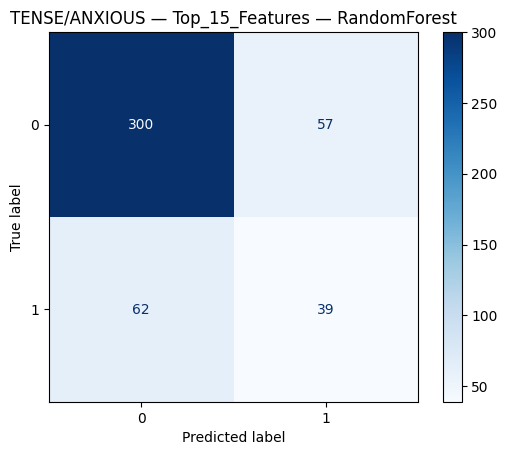


=== TENSE/ANXIOUS | Top_15_Features | GradientBoosting ===


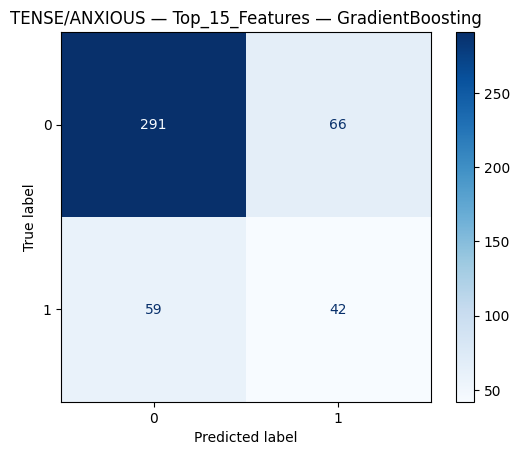


=== TENSE/ANXIOUS | Baseline (Median/Freq Impute) | RandomForest ===


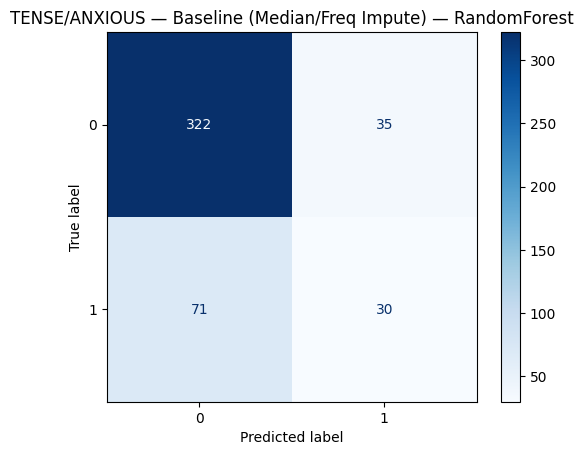


=== TENSE/ANXIOUS | Top_10_Features | GradientBoosting ===


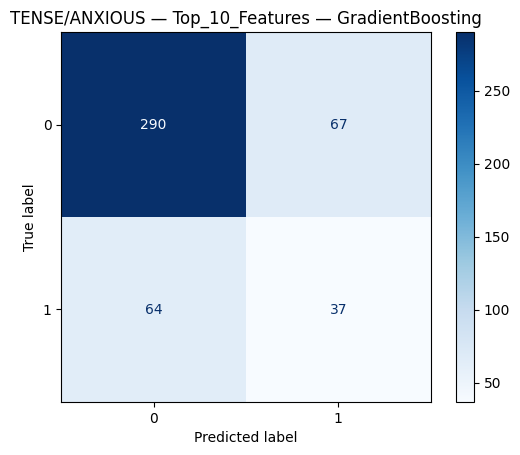


=== TENSE/ANXIOUS | KNN_Imputation | RandomForest ===


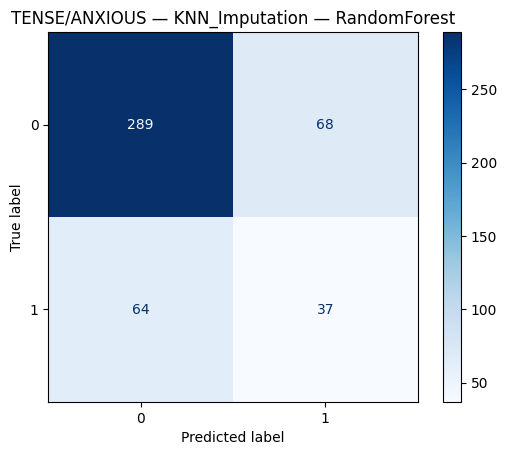


=== TIRED | Top_15_Features | GradientBoosting ===


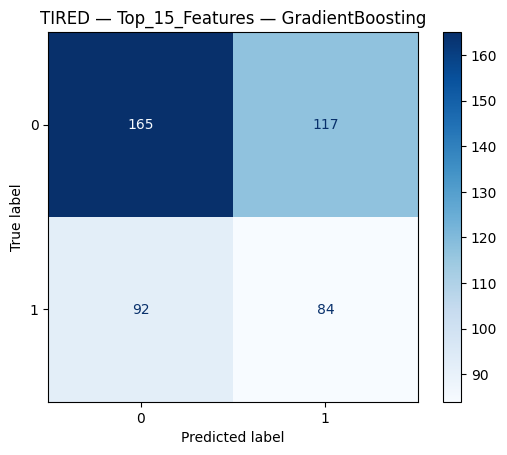


=== TIRED | Baseline (Median/Freq Impute) | RandomForest ===


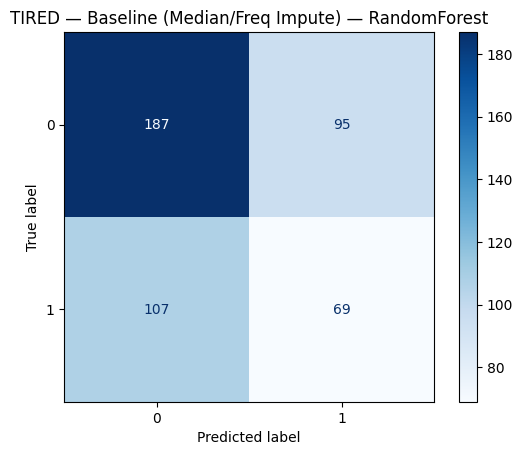


=== TIRED | PCA_25 | MLP ===


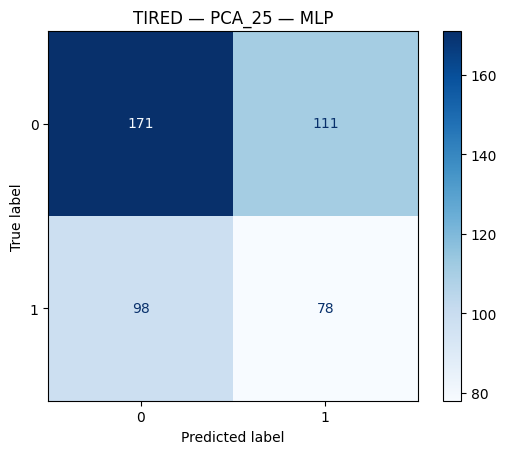


=== TIRED | PCA_15 | RandomForest ===


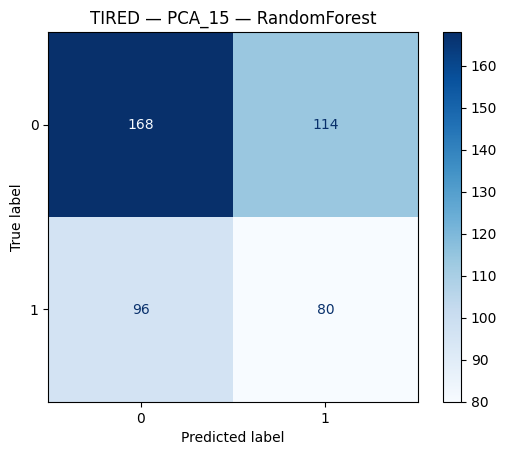


=== TIRED | Top_10_Features | GradientBoosting ===


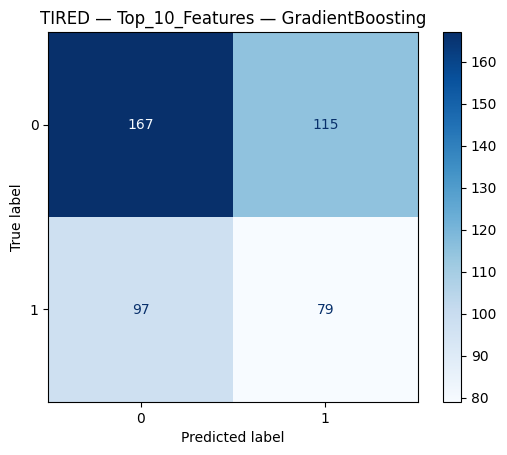

In [17]:
# Mapeig dels test sets per cada target
test_sets = {
    "TENSE/ANXIOUS": (X_test, y_tense_test),
    "TIRED":          (X_test, y_tired_test)
}

# Per cada target, agafa les 5 millors (ja que combined_results_sorted està ordenat descendent per Test F1-Macro)
for target in combined_results_sorted["Target"].unique():
    top5 = combined_results_sorted[
        combined_results_sorted["Target"] == target
    ].head(5)

    for _, row in top5.iterrows():
        experiment = row["Experiment"]
        model_name = row["Model"]

        print(f"\n=== {target} | {experiment} | {model_name} ===")

        # Selecciona el model segons l'experiment
        if experiment == "Baseline (Median/Freq Impute)":
            model = baseline_models[target][model_name]
        elif experiment.startswith("Top_"):
            n = int(experiment.split("_")[1])
            model = fi_models[target][n][model_name]
        elif experiment.startswith("PCA_"):
            n = int(experiment.split("_")[1])
            model = pca_models[target][n][model_name]
        elif experiment == "KNN_Imputation":
            model = knn_imputation_models[target][model_name]
        elif experiment == "Target_Augmentation":
            model = target_augmentation_models[target][model_name]
        else:
            raise ValueError(f"Experiment desconegut: {experiment}")

        # Prepara dades de test i prediccions
        X_test_target, y_true = test_sets[target]
        y_pred = model.predict(X_test_target)

        # Calcula i mostra la matriu de confusió
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                      display_labels=model.classes_)
        disp.plot(cmap="Blues")
        plt.title(f"{target} — {experiment} — {model_name}")
        plt.show()

In [1]:
# Nueva celda para imprimir los parámetros de cada modelo

def print_model_params(model_dict, exp_name):
    print(f"\n=== Parámetros para experimento: {exp_name} ===")
    for target, models in model_dict.items():
        print(f"\n-- Target: {target} --")
        for model_name, model in models.items():
            try:
                params = model.named_steps["classifier"].get_params()
                print(f"\nModelo: {model_name}")
                print(params)
            except Exception as e:
                print(f"Error obteniendo parámetros para {model_name}: {e}")


# Parámetros para el experimento Baseline (Median/Freq Impute)
print_model_params(baseline_models, "Baseline (Median/Freq Impute)")

# Parámetros para el experimento Feature Importance (Top Features)
for n_features in [10, 15]:
    print(f"\n=== Parámetros para experimento: Top {n_features} Features ===")
    for target, exp_dict in fi_models.items():
        if n_features in exp_dict:
            print(f"\n-- Target: {target} --")
            for model_name, model in exp_dict[n_features].items():
                try:
                    params = model.named_steps["classifier"].get_params()
                    print(f"\nModelo: {model_name}")
                    print(params)
                except Exception as e:
                    print(f"Error obteniendo parámetros para {model_name}: {e}")

# Parámetros para el experimento PCA
for n_components in [5, 10, 15, 20, 25]:
    print(f"\n=== Parámetros para experimento: PCA con {n_components} componentes ===")
    for target, exp_dict in pca_models.items():
        if n_components in exp_dict:
            print(f"\n-- Target: {target} --")
            for model_name, model in exp_dict[n_components].items():
                try:
                    params = model.named_steps["classifier"].get_params()
                    print(f"\nModelo: {model_name}")
                    print(params)
                except Exception as e:
                    print(f"Error obteniendo parámetros para {model_name}: {e}")

# Parámetros para el experimento KNN Imputation
print("\n=== Parámetros para experimento: KNN Imputation ===")
for target, models in knn_imputation_models.items():
    print(f"\n-- Target: {target} --")
    for model_name, model in models.items():
        try:
            params = model.named_steps["classifier"].get_params()
            print(f"\nModelo: {model_name}")
            print(params)
        except Exception as e:
            print(f"Error obteniendo parámetros para {model_name}: {e}")

# Parámetros para el experimento Target Augmentation
print("\n=== Parámetros para experimento: Target Augmentation ===")
for target, models in target_augmentation_models.items():
    print(f"\n-- Target: {target} --")
    for model_name, model in models.items():
        try:
            params = model.named_steps["classifier"].get_params()
            print(f"\nModelo: {model_name}")
            print(params)
        except Exception as e:
            print(f"Error obteniendo parámetros para {model_name}: {e}")

NameError: name 'baseline_models' is not defined